#STEP 1 — Data Merging & Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


In [3]:
# Upload CSVs in Colab or read from Drive
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")


In [7]:
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment = sentiment[['date','classification','value']]


In [8]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])


In [9]:
df = pd.merge(trades, sentiment, on='date', how='left')
print(df.shape)
df[['date','classification','Closed PnL']].head()


(211224, 19)


,date,classification,Closed PnL
0,2024-02-12,Greed,0.0
1,2024-02-12,Greed,0.0
2,2024-02-12,Greed,0.0
3,2024-02-12,Greed,0.0
4,2024-02-12,Greed,0.0


In [10]:
sentiment_sorted = sentiment.sort_values('date')
sentiment_sorted['sent_score'] = sentiment_sorted['classification'].map({
    'Extreme Fear':0,'Fear':1,'Neutral':2,'Greed':3,'Extreme Greed':4
})

sentiment_sorted['Sentiment_Shift'] = sentiment_sorted['sent_score'].diff()

df = df.merge(sentiment_sorted[['date','Sentiment_Shift']], on='date', how='left')


In [11]:
df['Risk_Ratio'] = df['Size USD'] / (df['Start Position'].abs() + 1)


In [12]:
df['Profit_Efficiency'] = df['Closed PnL'] / (df['Size USD'] + 1e-6)


In [13]:
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[col] >= Q1 - 1.5*IQR) & (data[col] <= Q3 + 1.5*IQR)]

df = remove_outliers(df, 'Closed PnL')
df = remove_outliers(df, 'Size USD')


#STEP 2 — Behavioral Analysis & Strategy Signals

In [15]:
# Average exposure by sentiment
sentiment_exposure = df.groupby('classification')['Size USD'].mean().sort_values()

sentiment_exposure


,Size USD
classification,
Neutral,439.529735
Extreme Greed,499.320458
Greed,635.033499
Fear,656.689501
Extreme Fear,672.251737


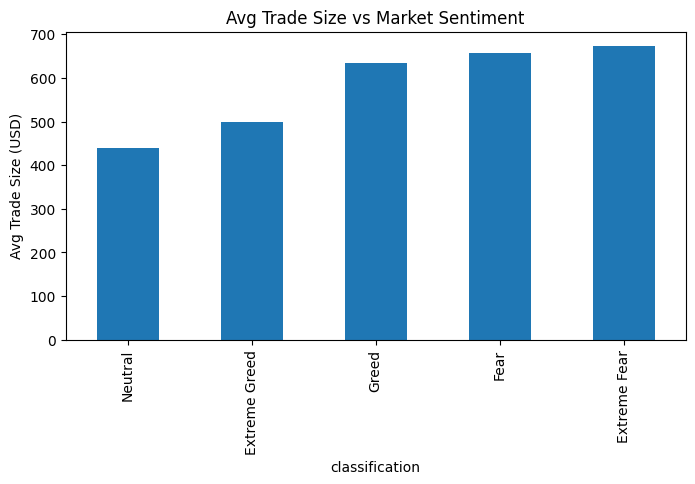

In [16]:
import matplotlib.pyplot as plt

sentiment_exposure.plot(kind='bar', figsize=(8,4), title="Avg Trade Size vs Market Sentiment")
plt.ylabel("Avg Trade Size (USD)")
plt.show()


In [17]:
pnl_sent = df.groupby('classification')['Closed PnL'].mean().sort_values()
pnl_sent


,Closed PnL
classification,
Extreme Fear,0.525613
Fear,1.033958
Greed,1.297082
Neutral,1.538654
Extreme Greed,1.899197


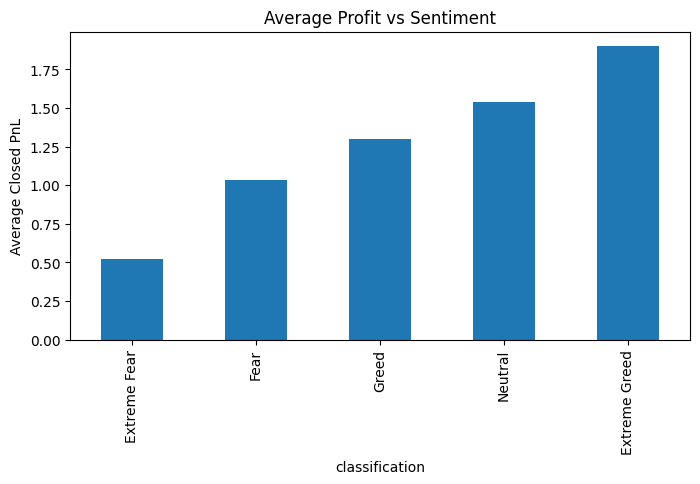

In [18]:
pnl_sent.plot(kind='bar', figsize=(8,4), title="Average Profit vs Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


In [19]:
fear_df = df[df['classification'].isin(['Extreme Fear','Fear'])]

alpha = fear_df.groupby('Account')['Closed PnL'].sum().reset_index()
alpha = alpha.sort_values('Closed PnL', ascending=False)

top_alpha = alpha.head(int(len(alpha)*0.10))   # top 10%
top_alpha.head()


,Account,Closed PnL
28,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,1757.887344
2,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1186.451591


In [20]:
top_accounts = top_alpha['Account']

top_trades = df[df['Account'].isin(top_accounts)]

daily_pnl = top_trades.groupby('date')['Closed PnL'].sum().cumsum()

sent_score = sentiment.set_index('date')['classification'].map({
    'Extreme Fear':0,'Fear':1,'Neutral':2,'Greed':3,'Extreme Greed':4
})


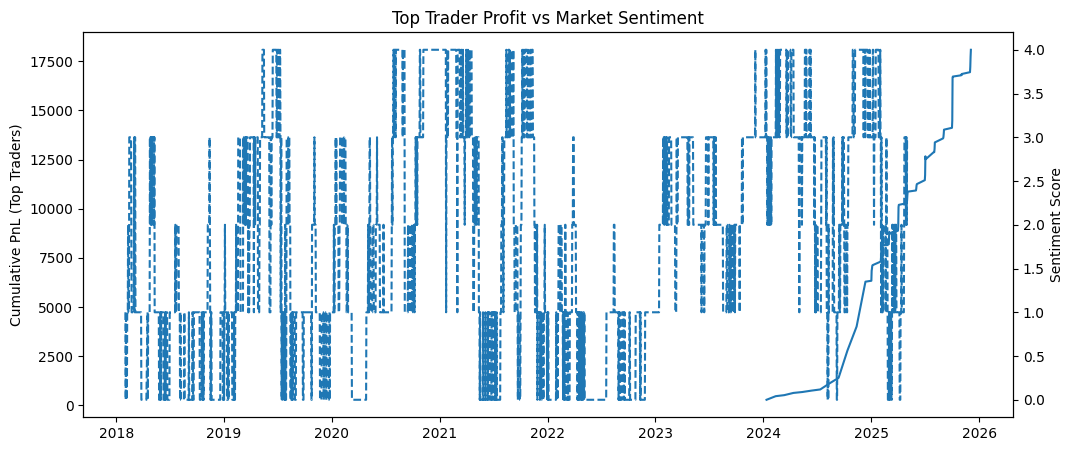

In [21]:
plt.figure(figsize=(12,5))

plt.plot(daily_pnl.index, daily_pnl.values)
plt.ylabel("Cumulative PnL (Top Traders)")

plt.twinx()
plt.plot(sent_score.index, sent_score.values, linestyle='dashed')
plt.ylabel("Sentiment Score")

plt.title("Top Trader Profit vs Market Sentiment")
plt.show()
